### CV - image classification, Image segemation , Image object detection


In [1]:
import torch
import torchvision
import torch.nn as nn 
from torch.utils.data import DataLoader , Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.optim as opti

In [2]:
import pandas as pd
df = pd.read_csv("Dataset/Mnist/train.csv")
df = df[:10000]

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

y = df["label"]
x = df.drop(columns= ["label"])
x_train , x_test , y_train , y_test  = train_test_split(x , y , test_size= 0.2 , random_state= 42)
x_train.shape , y_train.shape

x_train = np.array(x_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [4]:
x_train = x_train.reshape(x_train.shape[0] , 28 , 28)
x_test = x_test.reshape(x_test.shape[0] , 28 , 28)

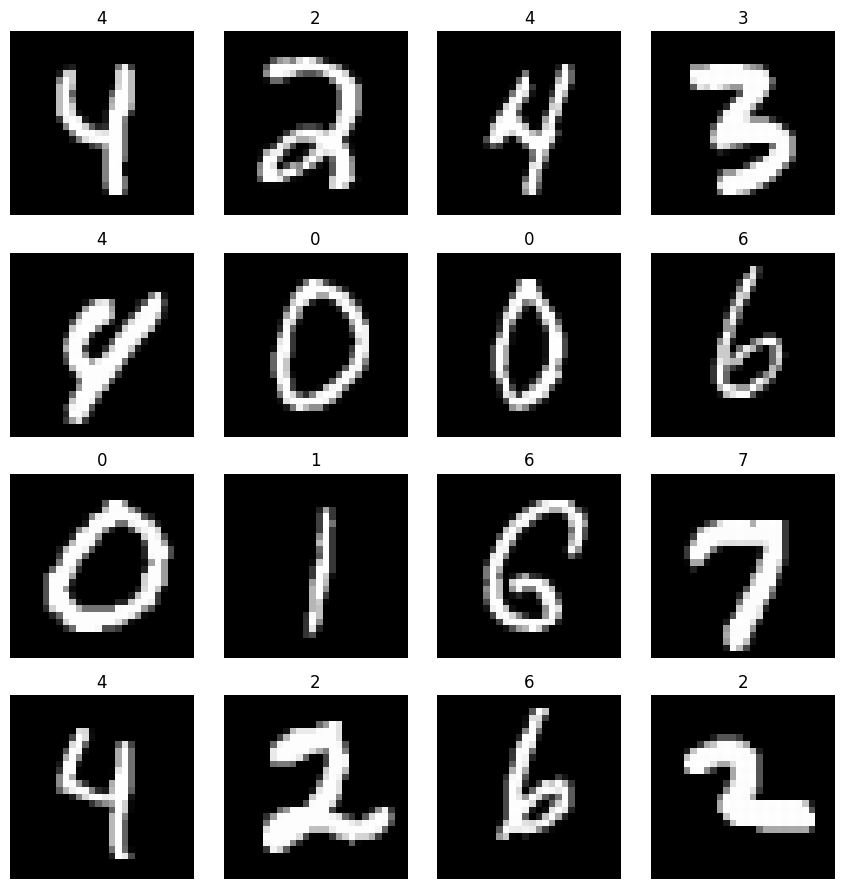

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9 , 9))
row, col = 4 , 4

for i in range(1, row*col+1):
    rand_inx = torch.randint(0 , len(x_train), size = [1]).item()
    
    fig.add_subplot(row , col , i)
    plt.imshow(x_train[rand_inx], cmap= "gray")
    plt.title(y_train[rand_inx])
    plt.axis(False)
    plt.tight_layout()

In [6]:
# Converting in tensors
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# To make the dim 
x_train = x_train.unsqueeze_(dim= 1)
x_test = x_test.unsqueeze_(dim= 1)

In [7]:
# Create Dataset
class CustomeDataset(Dataset):
    def __init__(self, features , labales):
        self.labels = labales
        self.features = features
        # Tranform data
        self.features = self.features.to(dtype = torch.float32)
        self.labels = self.labels.to(dtype = torch.long)
        self.features = self.features/255.0
        
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self , index):
        return self.features[index] , self.labels[index]
    

In [8]:
# Model Class
class NeuralNetwork(nn.Module):
    def __init__(self,features_count):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784 , 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256 , 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128 , 10)
        )
        
    def forward(self , features):
        out = self.network(features)
        return out
    
loss_function = nn.CrossEntropyLoss()

In [9]:
# Hyperparamter 
lr = 0.01
batch_size = 16
epochs = 20

In [10]:
# Train Dataset
train_dataset = CustomeDataset(x_train , y_train)
train_dataloder = DataLoader(train_dataset , shuffle= True , batch_size= batch_size)

# Test Dataset
test_dataset = CustomeDataset(x_test , y_test)
test_dataloder = DataLoader(test_dataset , shuffle= True , batch_size= batch_size)


In [11]:
for d , l in train_dataloder:
    print(d.shape) # shape of img data
    print(l.shape) # shape of label
    break

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [12]:
# Init model
device = torch.device("cude" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork(x_train.shape[0])
model = model.to(device)
opt = opti.Adam(model.parameters() , lr = lr , weight_decay= 1e-7)

In [13]:
x_train.shape

torch.Size([8000, 1, 28, 28])

In [14]:
from torchinfo import summary
# model.state_dict() another way to see the model paramater
summary(model , input_size=(8000, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [8000, 10]                --
├─Sequential: 1-1                        [8000, 10]                --
│    └─Flatten: 2-1                      [8000, 784]               --
│    └─Linear: 2-2                       [8000, 256]               200,960
│    └─BatchNorm1d: 2-3                  [8000, 256]               512
│    └─ReLU: 2-4                         [8000, 256]               --
│    └─Dropout: 2-5                      [8000, 256]               --
│    └─Linear: 2-6                       [8000, 128]               32,896
│    └─BatchNorm1d: 2-7                  [8000, 128]               256
│    └─ReLU: 2-8                         [8000, 128]               --
│    └─Dropout: 2-9                      [8000, 128]               --
│    └─Linear: 2-10                      [8000, 10]                1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0

In [27]:
# Accuracy function
def accuarcy_cal(y_true , y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct/len(y_pred)
    return acc*100

In [30]:
from tqdm.auto import tqdm

for epoch in tqdm(range(epochs)):
    batch_loss = 0
    for batch , (batch_feature , batch_label) in enumerate(train_dataloder):
        
        # Model in Traning Mode
        model.train()
        
        # Move to device
        batch_feature , batch_label = batch_feature.to(device) , batch_label.to(device)
        
        # forward 
        y_pred = model(batch_feature) 
        
        # Loss calculation
        loss = loss_function(y_pred , batch_label)
        batch_loss += loss
        
        # Backward 
        opt.zero_grad() 
        loss.backward()
        
        # Weight updates
        opt.step()
        
    # model in Evalution model
    
    test_loss, test_acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for batch_feature , batch_label in test_dataloder:
            
            # Forward pass   
            y_pred = model(batch_feature)
            
            # loss caculation
            test_loss += loss_function(y_pred , batch_label)
            
            # Calculate accuracy
            
            test_acc += accuarcy_cal(y_true= batch_label , y_pred= torch.argmax(y_pred , dim= 1))
        
        test_loss = test_loss/len(test_dataloder)
        test_acc /= len(test_dataloder)
    
    print(f"Epoch : {epoch+1} Train Loss : {batch_loss/len(train_dataloder)} Test Loss : {test_loss} Test accuracy : {test_acc}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 1 Train Loss : 0.19762083888053894 Test Loss : 0.12397927790880203 Test accuracy : 96.35
Epoch : 2 Train Loss : 0.18322524428367615 Test Loss : 0.1090831309556961 Test accuracy : 96.7
Epoch : 3 Train Loss : 0.18791761994361877 Test Loss : 0.1161140650510788 Test accuracy : 96.75
Epoch : 4 Train Loss : 0.19434577226638794 Test Loss : 0.1140095442533493 Test accuracy : 96.55
Epoch : 5 Train Loss : 0.1900174766778946 Test Loss : 0.11202647536993027 Test accuracy : 96.55
Epoch : 6 Train Loss : 0.17241159081459045 Test Loss : 0.1116248071193695 Test accuracy : 96.45
Epoch : 7 Train Loss : 0.17933030426502228 Test Loss : 0.1179431676864624 Test accuracy : 96.65
Epoch : 8 Train Loss : 0.17379061877727509 Test Loss : 0.11149494349956512 Test accuracy : 96.9
Epoch : 9 Train Loss : 0.17881786823272705 Test Loss : 0.12745293974876404 Test accuracy : 96.7
Epoch : 10 Train Loss : 0.16799981892108917 Test Loss : 0.11547832936048508 Test accuracy : 96.65
Epoch : 11 Train Loss : 0.178663983941

In [32]:
model.eval()
temp = model(test_dataset[:10][0])
torch.argmax(temp, dim = 1) , test_dataset[:10][1]

(tensor([2, 7, 8, 2, 3, 1, 2, 7, 1, 9]),
 tensor([2, 7, 8, 2, 3, 1, 2, 7, 1, 9]))

In [33]:
print(accuarcy_cal(torch.argmax(temp, dim = 1) , test_dataset[:10][1]))

100.0


In [128]:
# CNN Based Model

class CNNModel(nn.Module):
    def __init__(self ):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels= 10 , bias= True , kernel_size= 3 , padding = "same"),
            nn.ReLU(),
            nn.Conv2d(10 , 10 , 3 , 1 , "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels= 10, out_channels= 10 , bias= True , kernel_size= 3 , padding = "same"),
            nn.ReLU(),
            nn.Conv2d(10 , 10 , 3 , 1 , "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)  
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 10*7*7 , out_features= 10)
        )
        
        
    def forward(self , features):
        out1 = self.conv_block1(features)
        # print(out1.shape)  # Trick 
        out2 = self.conv_block2(out1)
        # print(out2.shape)
        out3 = self.classify(out2)
        # print(out3.shape)
        return out3

In [129]:
# Visualise Model
from torchinfo import  summary
CNNmodel = CNNModel()
summary(CNNmodel , input_size=(16 , 1 , 28 , 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [16, 10]                  --
├─Sequential: 1-1                        [16, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [16, 10, 28, 28]          100
│    └─ReLU: 2-2                         [16, 10, 28, 28]          --
│    └─Conv2d: 2-3                       [16, 10, 28, 28]          910
│    └─ReLU: 2-4                         [16, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [16, 10, 14, 14]          --
├─Sequential: 1-2                        [16, 10, 7, 7]            --
│    └─Conv2d: 2-6                       [16, 10, 14, 14]          910
│    └─ReLU: 2-7                         [16, 10, 14, 14]          --
│    └─Conv2d: 2-8                       [16, 10, 14, 14]          910
│    └─ReLU: 2-9                         [16, 10, 14, 14]          --
│    └─MaxPool2d: 2-10                   [16, 10, 7, 7]            --
├─Sequentia

In [130]:
# Function to Train the model
def training_step(model: torch.nn.Module,
                  train_dataloder : torch.utils.data.DataLoader,
                  loss_function : torch.nn.Module,
                  opt: torch.nn.Module,
                  accuarcy_cal, 
                  device: torch.device = device):
    batch_loss = 0
    traning_acc = 0
    for batch , (batch_feature , batch_label) in enumerate(train_dataloder):
        
        # Model in Traning Mode
        model.train()
        
        # Move to device
        batch_feature , batch_label = batch_feature.to(device) , batch_label.to(device)
        
        # forward 
        y_pred = model(batch_feature) 
        
        # Loss calculation
        loss = loss_function(y_pred , batch_label)
        batch_loss += loss
        
        # loss and accuracy Update
        acc = accuarcy_cal(y_true=batch_label , y_pred= torch.argmax(y_pred , dim = 1))
        traning_acc += acc
        
        
        # Backward 
        opt.zero_grad() 
        loss.backward()
        
        # Weight updates
        opt.step()
        
    traning_acc /= len(train_dataloder)
    batch_loss /= len(train_dataloder)
    print(f"Traning Loss : {batch_loss} , Traning Acc : {traning_acc}")

In [131]:
# function to for model testing
def testing_step(model: torch.nn.Module,
                  test_dataloder : torch.utils.data.DataLoader,
                  loss_function : torch.nn.Module,
                  accuarcy_cal,
                  device: torch.device = device):
    test_loss, test_acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for batch_feature , batch_label in test_dataloder:
            
            # for GPU
            batch_feature , batch_label = batch_feature.to(device) , batch_label.to(device)
            
            # Forward pass   
            y_pred = model(batch_feature)
            
            # loss caculation
            test_loss += loss_function(y_pred , batch_label)
            
            # Calculate accuracy
            
            test_acc += accuarcy_cal(y_true= batch_label , y_pred= torch.argmax(y_pred , dim= 1))
        
        test_loss /= len(test_dataloder)
        test_acc /= len(test_dataloder)
    
    print(f"Test Loss : {test_loss}, Test accuracy : {test_acc}")

In [132]:
for ep in tqdm(range(2)):
    print(f"Epoch : {ep+1}")
    training_step(model , train_dataloder , loss_function , opt , accuarcy_cal )
    testing_step(model  ,test_dataloder , loss_function , accuarcy_cal )
    

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 1
Traning Loss : 0.13407564163208008 , Traning Acc : 95.775
Test Loss : 0.12465064227581024, Test accuracy : 96.75
Epoch : 2
Traning Loss : 0.14777807891368866 , Traning Acc : 95.3875
Test Loss : 0.11641119420528412, Test accuracy : 97.1


In [133]:
# Hyperparameter
lr = 0.01
batch_sizes = 16
epochs = 20
loss_func = nn.CrossEntropyLoss()
optimiser = opti.Adam(CNNmodel.parameters() , lr = lr)

In [134]:
# Train Model
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    training_step(CNNmodel , train_dataloder , loss_func , optimiser , accuarcy_cal)
    testing_step(CNNmodel , test_dataloder , loss_func , accuarcy_cal)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Traning Loss : 0.4565892815589905 , Traning Acc : 85.0625
Test Loss : 0.20806631445884705, Test accuracy : 93.1
Epoch: 1
---------
Traning Loss : 0.1619330197572708 , Traning Acc : 94.9875
Test Loss : 0.14040736854076385, Test accuracy : 95.7
Epoch: 2
---------
Traning Loss : 0.13808496296405792 , Traning Acc : 95.6375
Test Loss : 0.13501334190368652, Test accuracy : 95.45
Epoch: 3
---------
Traning Loss : 0.10790326446294785 , Traning Acc : 96.425
Test Loss : 0.18311966955661774, Test accuracy : 95.45
Epoch: 4
---------
Traning Loss : 0.09458000957965851 , Traning Acc : 96.8
Test Loss : 0.15071836113929749, Test accuracy : 95.7
Epoch: 5
---------
Traning Loss : 0.09789732098579407 , Traning Acc : 96.7125
Test Loss : 0.14207971096038818, Test accuracy : 96.0
Epoch: 6
---------
Traning Loss : 0.09766189754009247 , Traning Acc : 96.7875
Test Loss : 0.15061767399311066, Test accuracy : 96.0
Epoch: 7
---------
Traning Loss : 0.08135518431663513 , Traning Acc : 97.4
Test 

In [189]:
# Made Predictions
def make_predction(model:nn.Module,
                   img: list,
                   device: torch.device = device):
    model.to(device= device)
    model.eval()
    
    with torch.inference_mode():
        # img = torch.tensor(img)
        img = torch.unsqueeze(img , dim=0).to(device=device)
        output = model(img)
        
        label = torch.argmax(output.squeeze() , dim = 0).item()
        
    return torch.tensor(label)   

In [229]:
import random
# random.seed(42)
test_sample = []
test_label = []
predict_lables = []
for sample , label in random.sample(list(test_dataset) , k = 9):
    test_sample.append(sample)
    test_label.append(label)
    predict_lables.append(make_predction(CNNmodel , sample))

    

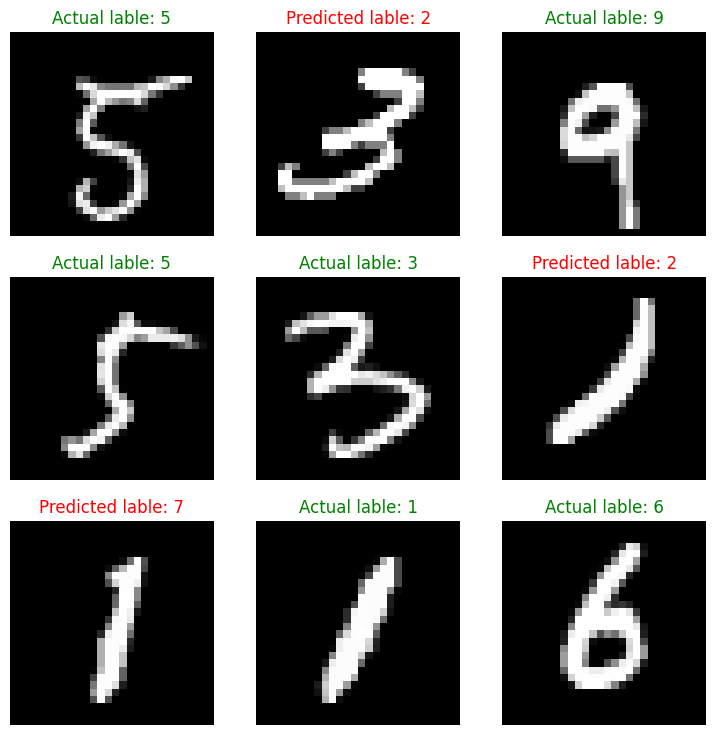

In [230]:
fig = plt.figure(figsize=(9 , 9))
row , col = 3 , 3

for i , sample in enumerate(test_sample):
    
    plt.subplot(row , col , i+1)
    
    plt.imshow(sample.squeeze() , cmap = "gray")
    
    if test_label[i] == predict_lables[i]:
        plt.title(f"Actual lable: {test_label[i].item()}" , c = "g" )
        
    else:
        plt.title(f"Predicted lable: {predict_lables[i].item()}" , c = "r" )
    plt.axis(False)
    
    

In [3]:
# Confusion matrix
!pip install torchmetrics


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\singh\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip
